<a href="https://colab.research.google.com/github/saumya0303/Adversarial-Patch/blob/main/AdversarialPatch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Trusted-AI/adversarial-robustness-toolbox.git
import os
os.chdir('/content/adversarial-robustness-toolbox')
!pip install tensorflow-addons
!pip install git+https://github.com/nottombrown/imagenet_stubs

fatal: destination path 'adversarial-robustness-toolbox' already exists and is not an empty directory.
  Cloning https://github.com/nottombrown/imagenet_stubs to /tmp/pip-req-build-ve4u5ynd
  Running command git clone -q https://github.com/nottombrown/imagenet_stubs /tmp/pip-req-build-ve4u5ynd
  Created wheel for imagenet-stubs: filename=imagenet_stubs-0.0.7-cp37-none-any.whl size=794842 sha256=992c2a09344507811ec915735e2b938f73ffb2bd190bf912c3aabd563d1eb948
  Stored in directory: /tmp/pip-ephem-wheel-cache-ncqw5m8u/wheels/ae/51/e7/c1cfa8692ea864410aa778b169fc7766af073ac52a1bc23301
Successfully built imagenet-stubs


In [2]:
import warnings
warnings.filterwarnings('ignore')

import random
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import name_to_label

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

from art.estimators.classification import TensorFlowV2Classifier, EnsembleClassifier
from art.attacks.evasion import AdversarialPatch

In [3]:
target_name = 'toaster'
image_shape = (224, 224, 3)
clip_values = (0, 255)
nb_classes  =1000
batch_size = 16
scale_min = 0.4
scale_max = 1.0
rotation_max = 22.5
learning_rate = 5000.
max_iter = 500

In [4]:
model = tf.keras.applications.resnet50.ResNet50(weights="imagenet")

mean_b = 103.939
mean_g = 116.779
mean_r = 123.680

tfc = TensorFlowV2Classifier(model=model, loss_object=None, train_step=None, nb_classes=nb_classes,
                             input_shape=image_shape, clip_values=clip_values, 
                             preprocessing=([mean_b, mean_g, mean_r], 1))

102973440/102967424 [==============================] - 3s 0us/step


In [5]:
images_list = list()

for image_path in imagenet_stubs.get_image_paths():
    im = image.load_img(image_path, target_size=(224, 224))
    im = image.img_to_array(im)
    im = im[:, :, ::-1].astype(np.float32) # RGB to BGR
    im = np.expand_dims(im, axis=0)
    images_list.append(im)

images = np.vstack(images_list)

In [6]:
def bgr_to_rgb(x):
    return x[:, :, ::-1]

In [7]:
ap = AdversarialPatch(classifier=tfc, rotation_max=rotation_max, scale_min=scale_min, scale_max=scale_max,
                      learning_rate=learning_rate, max_iter=max_iter, batch_size=batch_size,
                      patch_shape=(224, 224, 3))

label = name_to_label(target_name)
y_one_hot = np.zeros(nb_classes)
y_one_hot[label] = 1.0
y_target = np.tile(y_one_hot, (images.shape[0], 1))

patch, patch_mask = ap.generate(x=images, y=y_target)

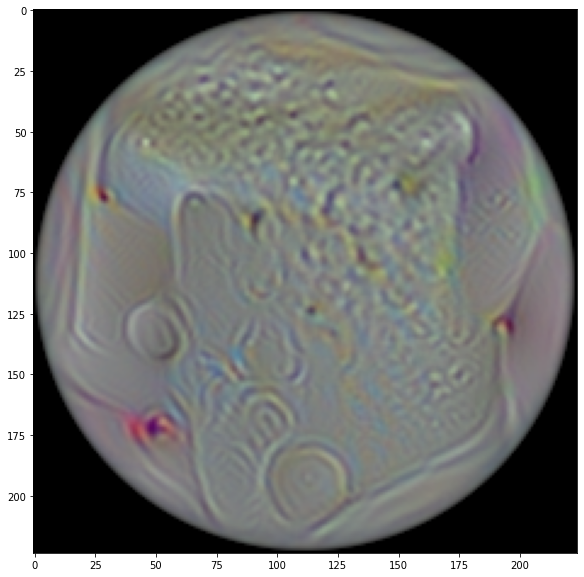

In [8]:
plt.imshow((bgr_to_rgb(patch) * patch_mask).astype(np.uint8))

In [9]:
patched_images = ap.apply_patch(images, scale=0.5)

In [10]:

def predict_model(classifier, image):
    plt.imshow(bgr_to_rgb(image.astype(np.uint8)))
    plt.show()
    
    image = np.copy(image)
    image = np.expand_dims(image, axis=0)
    
    prediction = classifier.predict(image)
    
    top = 5
    prediction_decode = decode_predictions(prediction, top=top)[0]
    print('Predictions:')
    
    lengths = list()
    for i in range(top):
        lengths.append(len(prediction_decode[i][1]))
    max_length = max(lengths)
    
    for i in range(top):
        name = prediction_decode[i][1]
        name = name.ljust(max_length, " ")
        probability = prediction_decode[i][2]
        output_str = "{} {:.2f}".format(name, probability)
        print(output_str)

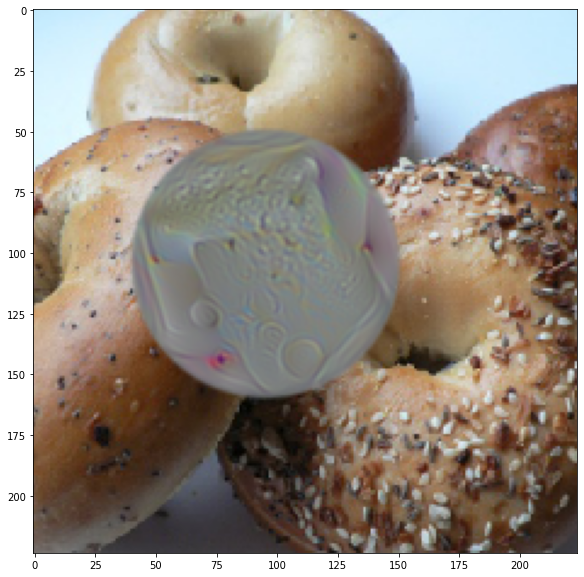

40960/35363 [==================================] - 0s 0us/step
Predictions:
bagel   0.66
toaster 0.34
pretzel 0.00
bakery  0.00
eggnog  0.00


In [11]:
predict_model(tfc, patched_images[0])

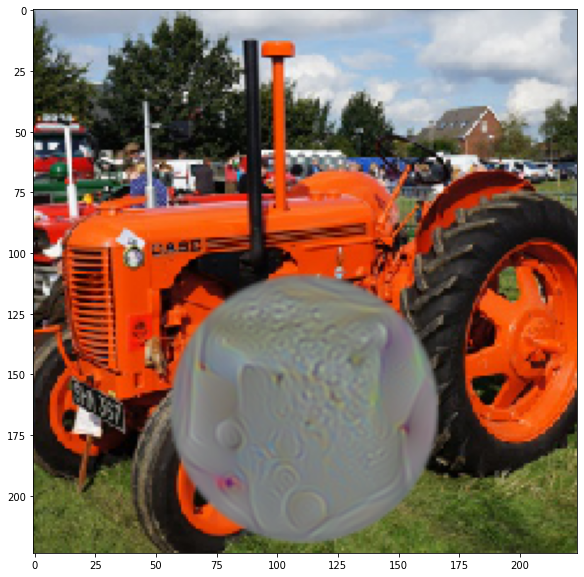

Predictions:
tractor   0.95
thresher  0.03
plow      0.01
harvester 0.01
toaster   0.01


In [12]:
predict_model(tfc, patched_images[1])

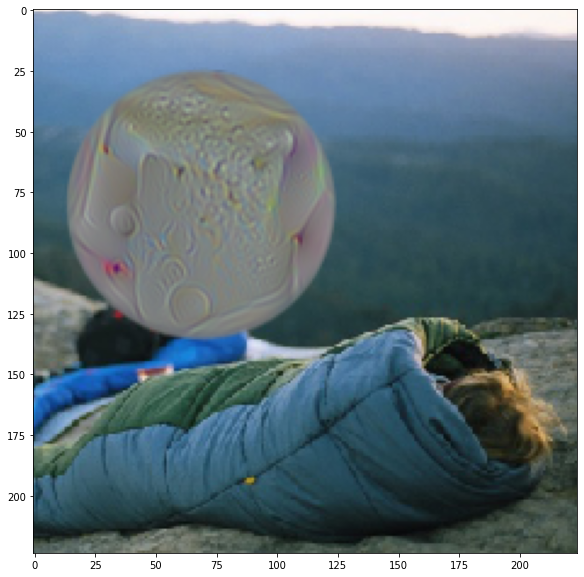

Predictions:
toaster        1.00
coffee_mug     0.00
sewing_machine 0.00
piggy_bank     0.00
space_heater   0.00


In [13]:
predict_model(tfc, patched_images[2])